ProblemSet 7

Q1. Split the data into a training set (70%) and a test set (30%) using the sklearn.model_selection.train_test_split() function with random_state=25. Setting the seed will guarantee you all get the same results. Use recursive binary splitting to fit a decision tree to the training data, with biden as the response variable and the other variables as predictors. Set the max_depth=3 and min_samples_leaf=5. Plot the tree and interpret the results. What is the test MSE?

Train size: 1264   Test size: 543

=== Question 1: Baseline Regression Tree ===

|--- dem <= 0.50
|   |--- rep <= 0.50
|   |   |--- female <= 0.50
|   |   |   |--- value: [56.49]
|   |   |--- female >  0.50
|   |   |   |--- value: [61.27]
|   |--- rep >  0.50
|   |   |--- female <= 0.50
|   |   |   |--- value: [38.33]
|   |   |--- female >  0.50
|   |   |   |--- value: [44.89]
|--- dem >  0.50
|   |--- age <= 54.50
|   |   |--- educ <= 15.50
|   |   |   |--- value: [71.11]
|   |   |--- educ >  15.50
|   |   |   |--- value: [76.59]
|   |--- age >  54.50
|   |   |--- female <= 0.50
|   |   |   |--- value: [75.19]
|   |   |--- female >  0.50
|   |   |   |--- value: [80.29]


Feature importances:
 dem       0.707531
rep       0.231687
female    0.031767
age       0.019312
educ      0.009703

Baseline Test MSE: 396.193715  (RMSE: 19.9046)


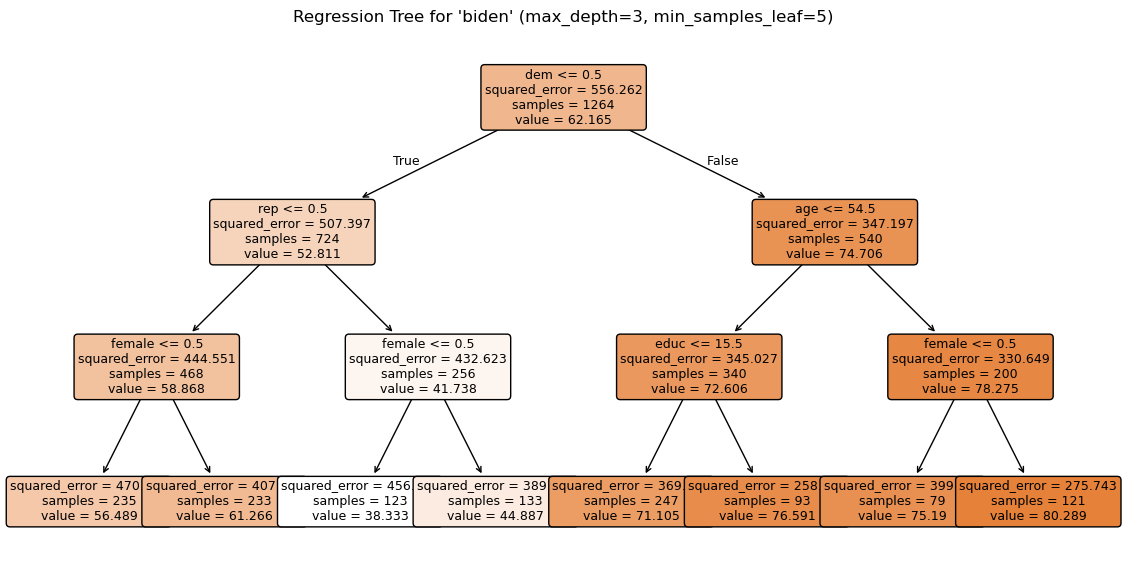

In [2]:
"""
Biden Regression Tree and Model Tuning
======================================
Performs three tasks:
  1. Baseline regression tree (max_depth=3, min_samples_leaf=5)
  2. RandomizedSearchCV tuning for DecisionTreeRegressor
  3. RandomizedSearchCV tuning for RandomForestRegressor
  4. Compares MSEs across models

Dataset: 'biden.csv'
Columns: ['biden','female','age','dem','rep','educ']
"""

# %%
from pprint import pprint
import pandas as pd
import numpy as np
from scipy.stats import randint as sp_randint

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor, export_text, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Configuration
CSV = "biden.csv"
PREDICTORS = ['female', 'age', 'dem', 'rep', 'educ']
TEST_SIZE = 0.30
RANDOM_STATE = 25
N_ITER = 100
CV = 5
N_JOBS = -1
SCORING = 'neg_mean_squared_error'


# %%
def load_and_split(path=CSV, test_size=TEST_SIZE, random_state=RANDOM_STATE):
    """Load CSV and return X_train, X_test, y_train, y_test (shared across tasks)."""
    df = pd.read_csv(path)
    X = df[PREDICTORS]
    y = df['biden']
    return train_test_split(X, y, test_size=test_size, random_state=random_state)


def fit_baseline_tree(X_train, y_train, X_test, y_test, random_state=RANDOM_STATE):
    """Question 1: Baseline regression tree with plot, textual output, and MSE."""
    tree = DecisionTreeRegressor(max_depth=3, min_samples_leaf=5, random_state=random_state)
    tree.fit(X_train, y_train)

    print("\n=== Question 1: Baseline Regression Tree ===\n")
    print(export_text(tree, feature_names=PREDICTORS))

    fi = pd.Series(tree.feature_importances_, index=PREDICTORS).sort_values(ascending=False)
    print("\nFeature importances:\n", fi.to_string())

    y_pred = tree.predict(X_test)
    test_mse = mean_squared_error(y_test, y_pred)
    print(f"\nBaseline Test MSE: {test_mse:.6f}  (RMSE: {np.sqrt(test_mse):.4f})")

    # Plot tree
    plt.figure(figsize=(14, 7))
    plot_tree(tree, feature_names=PREDICTORS, filled=True, rounded=True, fontsize=9)
    plt.title("Regression Tree for 'biden' (max_depth=3, min_samples_leaf=5)")
    plt.show()

    return tree, test_mse


X_train, X_test, y_train, y_test = load_and_split()
print(f"Train size: {X_train.shape[0]}   Test size: {X_test.shape[0]}")

# Question 1
baseline_tree, baseline_mse = fit_baseline_tree(X_train, y_train, X_test, y_test)


A1 : The regression tree results indicate that partisanship is the dominant factor influencing attitudes toward Joe Biden. The most important split in the tree occurs on whether people identify as a Democrat, which accounts 70% of the variation in feelings toward Biden. Among Democrats, predicted feelings are consistently warm, which are more than 70. Especially, people with highest warmth are older women, showing 80 scores. Among people who are relativelyt young, more educated people show higher warmth compared to uneducated people. Among non-Democrats, the next dominant factor occurs on whether people identify Republicans and non-Republicans. Republicans express the coldest feelings, while Independents show more moderate attitudes. Within each partisan group, gender exerts a modest influence, with women expressing slightly more warmth toward Biden than men.

The feature importance scores reinforce this interpretation. party affiliation including both dem and rec explain over 93% of the model’s predictive power, while others contribute only marginally. The test mean squared error (MSE) of 396.19, corresponding to an RMSE of about 19.9 points, suggests that the model provides reasonably accurate predictions given the 0–100 thermometer scale. Overall, attitudes toward Joe Biden in 2008 appear to be driven primarily by party affiliation, with smaller demographic differences within partisan groups.

Q2 : Use sklearn.model_selection.RandomizedSearchCV to optimally tune the hyperparameters in the decision tree from part (1). Tune the parameters max_depth, min_samples_split, and min_samples_leaf. Set n_iter=100, n_jobs=-1, cv=5 for k = 5 k-fold cross validation, random_state=25, and scoring='neg_mean_squared error'. This last option will allow you to compare the MSE of the optimized tree (it will output the negative MSE) to the MSE calculated in part (1). Set your parameter distributions over which to test random combinations to the following:
from scipy . stats import randint as sp_randint
param_dist = {" max_depth ": [3, 10],
" min_samples_split ": sp_randint (2, 20),
" min_samples_leaf ": sp_randint (2, 20)}
Report your optimal tuning parameter values (use the .best_params_ attribute of your RandomizedSearchCV().fit(X, y)) results. Report the MSE of your optimal results (use the .best_score_attribute of your RandomizedSearchCV().fit(X, y)) results.

In [4]:
def tune_decision_tree(X_train, y_train, X_test, y_test, random_state=RANDOM_STATE):
    """Question 2: RandomizedSearchCV tuning for DecisionTreeRegressor."""
    print("\n=== Question 2: Decision Tree Hyperparameter Tuning ===\n")
    base = DecisionTreeRegressor(random_state=random_state)
    param_dist = {
        "max_depth": [3, 10],
        "min_samples_split": sp_randint(2, 20),
        "min_samples_leaf": sp_randint(2, 20),
    }

    rs = RandomizedSearchCV(
        estimator=base,
        param_distributions=param_dist,
        n_iter=N_ITER,
        scoring=SCORING,
        cv=CV,
        random_state=random_state,
        n_jobs=N_JOBS,
        verbose=1,
    )
    rs.fit(X_train, y_train)

    print("\nBest Parameters:")
    pprint(rs.best_params_)
    best_cv_mse = -rs.best_score_
    print(f"Optimal Cross-Validated MSE (from .best_score_): {best_cv_mse:.6f}")

    best_est = rs.best_estimator_
    test_mse = mean_squared_error(y_test, best_est.predict(X_test))
    print(f"Test MSE (Optimized Tree): {test_mse:.6f}  (RMSE: {np.sqrt(test_mse):.4f})")

    return rs, best_cv_mse, test_mse

# Question 2
rs_tree, tree_cv_mse, tree_test_mse = tune_decision_tree(X_train, y_train, X_test, y_test)


=== Question 2: Decision Tree Hyperparameter Tuning ===

Fitting 5 folds for each of 100 candidates, totalling 500 fits

Best Parameters:
{'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 9}
Optimal Cross-Validated MSE (from .best_score_): 404.709941
Test MSE (Optimized Tree): 394.762000  (RMSE: 19.8686)


A2: The optimized Decision Tree achieved an average cross-validated MSE of 404.7 and a test MSE of 394.8, improving slightly over the baseline model. The optimal parameters (max_depth=3, min_samples_split=9, min_samples_leaf=2) indicate that a shallow tree with modest regularization best fits the data. The RMSE of about 19.9 suggests that the model’s predictions of attitudes toward Joe Biden are reasonable but not highly precise fit. Overall, tuning produced only marginal gains, implying that the baseline model was already good.

Q3: Now tune the parameteres of a RandomForest regression model on these data
sklearn.ensemble.RandomForestRegressor(). Use sklearn.model_selection.RandomizedSearchCV to optimally tune the hyperparameters in the random forest regression model. Tune the parameters n_estimators, max_depth, in_samples_split, min_samples_leaf, and max_features. Set n_iter=100, n_jobs=-1, cv=5 for k = 5 k-fold cross validation, random_state=25, and scoring='neg_mean_squared_error'. Set your Random Forest parameter distributions over which to test random combinations to the following:
param_dist = {" n_estimators ": [10 , 200],
" max_depth ": [3, 10],
" min_samples_split ": sp_randint (2, 20),
" min_samples_leaf ": sp_randint (2, 20),
" max_features ": sp_randint (1, 5)}
Report your optimal tuning parameter values (use the .best_params_ attribute of your RandomizedSearchCV().fit(X, y)) results. Report the MSE of your optimal results (use the .best_score_attribute of your RandomizedSearchCV().fit(X, y)) results.

In [5]:
def tune_random_forest(X_train, y_train, X_test, y_test, random_state=RANDOM_STATE):
    """Question 3: RandomizedSearchCV tuning for RandomForestRegressor."""
    print("\n=== Question 3: Random Forest Hyperparameter Tuning ===\n")
    base = RandomForestRegressor(random_state=random_state)
    param_dist = {
        "n_estimators": [10, 200],
        "max_depth": [3, 10],
        "min_samples_split": sp_randint(2, 20),
        "min_samples_leaf": sp_randint(2, 20),
        "max_features": sp_randint(1, 5),
    }

    rs = RandomizedSearchCV(
        estimator=base,
        param_distributions=param_dist,
        n_iter=N_ITER,
        scoring=SCORING,
        cv=CV,
        random_state=random_state,
        n_jobs=N_JOBS,
        verbose=1,
    )
    rs.fit(X_train, y_train)

    print("\nBest Parameters:")
    pprint(rs.best_params_)
    best_cv_mse = -rs.best_score_
    print(f"Optimal Cross-Validated MSE (from .best_score_): {best_cv_mse:.6f}")

    best_est = rs.best_estimator_
    test_mse = mean_squared_error(y_test, best_est.predict(X_test))
    print(f"Test MSE (Optimized Random Forest): {test_mse:.6f}  (RMSE: {np.sqrt(test_mse):.4f})")

    fi = pd.Series(best_est.feature_importances_, index=PREDICTORS).sort_values(ascending=False)
    print("\nFeature importances (Best RF):\n", fi.to_string())

    return rs, best_cv_mse, test_mse

# Question 3
rs_rf, rf_cv_mse, rf_test_mse = tune_random_forest(X_train, y_train, X_test, y_test)





=== Question 3: Random Forest Hyperparameter Tuning ===

Fitting 5 folds for each of 100 candidates, totalling 500 fits

Best Parameters:
{'max_depth': 3,
 'max_features': 3,
 'min_samples_leaf': 19,
 'min_samples_split': 2,
 'n_estimators': 200}
Optimal Cross-Validated MSE (from .best_score_): 398.201401
Test MSE (Optimized Random Forest): 391.552606  (RMSE: 19.7877)

Feature importances (Best RF):
 dem       0.531466
rep       0.382322
age       0.043760
female    0.022487
educ      0.019965


A3: The tuned Random Forest Regressor achieved a cross-validated MSE of 398.2 and a test MSE of 391.6, outperforming the baseline and optimized single-tree models slightly.
The optimal forest uses 200 shallow trees (max depth = 3) with strong regularization, emphasizing stability over complexity.
Feature importances reveal that party affiliation dominantly explains variation in feelings toward Joe Biden, while other play only minor roles. 
The small gap between CV MSE and test MSE indicates that the model generalizes well without overfitting, yielding a consistent predictive performance across both test and training data.